In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
df=pd.read_csv("Dataset .csv")

In [3]:
df.isnull().sum() #checking NaN values in the df

Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64

In [4]:
df=df.dropna() #handling missing values, deleting rows with missing values

In [5]:
le=LabelEncoder()
df["City_encoded"]=le.fit_transform(df["City"])
df["Has Table booking_encoded"]=df["Has Table booking"].map({"Yes":1, "No":0}) 
df["Has Online delivery_encoded"]=df["Has Online delivery"].map({"Yes":1, "No":0})

#splitting the cuisines column into a list of strings
df["Cuisines"] = df["Cuisines"].apply(lambda x: x.split(", ") if isinstance(x, str) else []) 

mlb = MultiLabelBinarizer()
cuisine_encoded = pd.DataFrame(mlb.fit_transform(df["Cuisines"]), columns=mlb.classes_)

df = pd.concat([df, cuisine_encoded], axis=1)

df.drop(columns=["Cuisines"], inplace=True)

cuisine_columns = list(mlb.classes_)# converting the array into list

In [6]:
df.isna().sum() # there can be some missing values coz we are not sure about the data, as we encoded some factors

Restaurant ID      9
Restaurant Name    9
Country Code       9
City               9
Address            9
                  ..
Turkish Pizza      9
Vegetarian         9
Vietnamese         9
Western            9
World Cuisine      9
Length: 168, dtype: int64

In [7]:
df=df.dropna() # drop rows with missing values

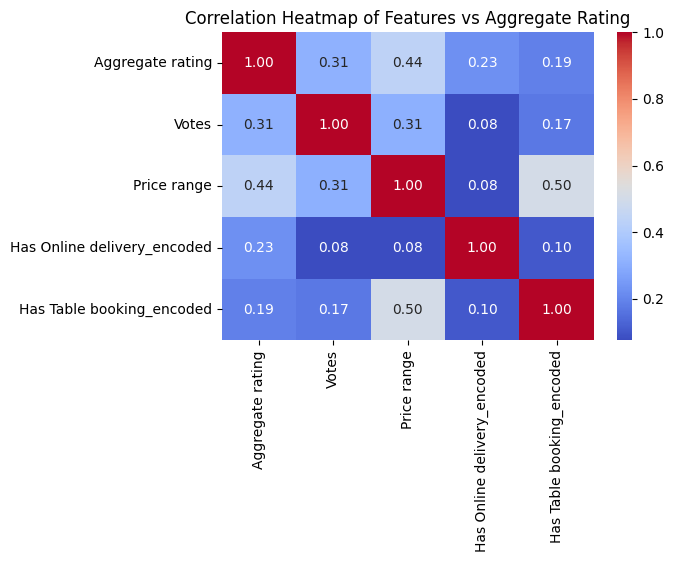

In [8]:
#using correlation matrix to see what factors does will correlate good with aggrerate rating
corr = df[["Aggregate rating", "Votes", "Price range", "Has Online delivery_encoded", "Has Table booking_encoded"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features vs Aggregate Rating")
plt.show()

In [9]:
X=df[["City_encoded", "Votes","Price range"] + cuisine_columns]
y=df["Aggregate rating"] # target

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42) #splitting the data into train and test

In [11]:
scaler=StandardScaler() # StandardScaler is used to scale the data
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [12]:
lin_model=LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred = lin_model.predict(X_test_scaled)
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))
print("Linear Regression R²:", r2_score(y_test, y_pred))

Linear Regression MSE: 1.6974610452529044
Linear Regression R²: 0.25872157400500884


above we can clearly observe R2 score is way less which is 0.25. This means linear model is not a good fit for this data.We can see that the model is not able to capture

In [13]:
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_dt))
print("Decision Tree R²:", r2_score(y_test, y_pred_dt))

Decision Tree MSE: 0.1361061103429898
Decision Tree R²: 0.94056268712292


In [14]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred))
print("Random Forest R²:", r2_score(y_test, y_pred))

Random Forest MSE: 0.13204662690652577
Random Forest R²: 0.9423354568136003


from above, we can clearly see RandomForestRgressor is performing better than DecisionTreeRegressor on given data. So, we can use RandomForestRegressor for our model.

In [15]:
importances = model.feature_importances_ 
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp_df.head(10))  # returns Top 10 influential features


          Feature  Importance
1           Votes    0.958260
0    City_encoded    0.014329
2     Price range    0.004455
37        Chinese    0.001927
103  North Indian    0.001726
52      Fast Food    0.001693
98        Mughlai    0.001224
40    Continental    0.001047
126  South Indian    0.000993
30           Cafe    0.000972


These are the top 10 influential features from that Votes plays a major role, and which will affect the restaurant rating

In [16]:
def preprocess_input(city, cuisine, votes,Price_range ,mlb, df):
    city_encoded = df["City_encoded"].unique()  # Get all unique city codes
    city_val = city_encoded[df["City"].unique().tolist().index(city)] if city in df["City"].unique() else 0

    cuisine_list = cuisine.split(", ")  # Converting input cuisine to list
    cuisine_encoded = mlb.transform([cuisine_list]) 


    input_data = np.array([city_val,votes,Price_range] + list(cuisine_encoded[0])) # Combining all inputs into an array

    return input_data.reshape(1, -1)

In [17]:
#user input
city_input = "New Delhi"
cuisine_input = "Italian, Chinese, North Indian, Bakery"
votes_input = 220
Price_range=2
# Preprocess the Input
X_new = preprocess_input(city_input, cuisine_input, votes_input,Price_range, mlb, df)

predicted_rating = model.predict(X_new)
print(f"Predicted Aggregate Rating: {predicted_rating[0]:.2f}")


Predicted Aggregate Rating: 4.35
